In [23]:
# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# Introduction


The universe evolved over time and as such the star formation rate and the metallicity of the starforming gas change. The ClassMSSFR is a script which determines the amount of star formation that went into forming a system born at redshift z, in a metallicity bin dZ. In shorthand we will use the term metallicity-specific star formation, either indicated with MSSFR or SFRD(Z,z), which is a function of metallicity Z and redshift z. We will both use MSSFR and SFRD(Z,z) throughout this notebook and they are identical (just two different ways of naming the concept). 

A schematic picture of how the SFRD(Z,z) is constructed is given in Figure 10 of the COMPAS methods paper and added below. 

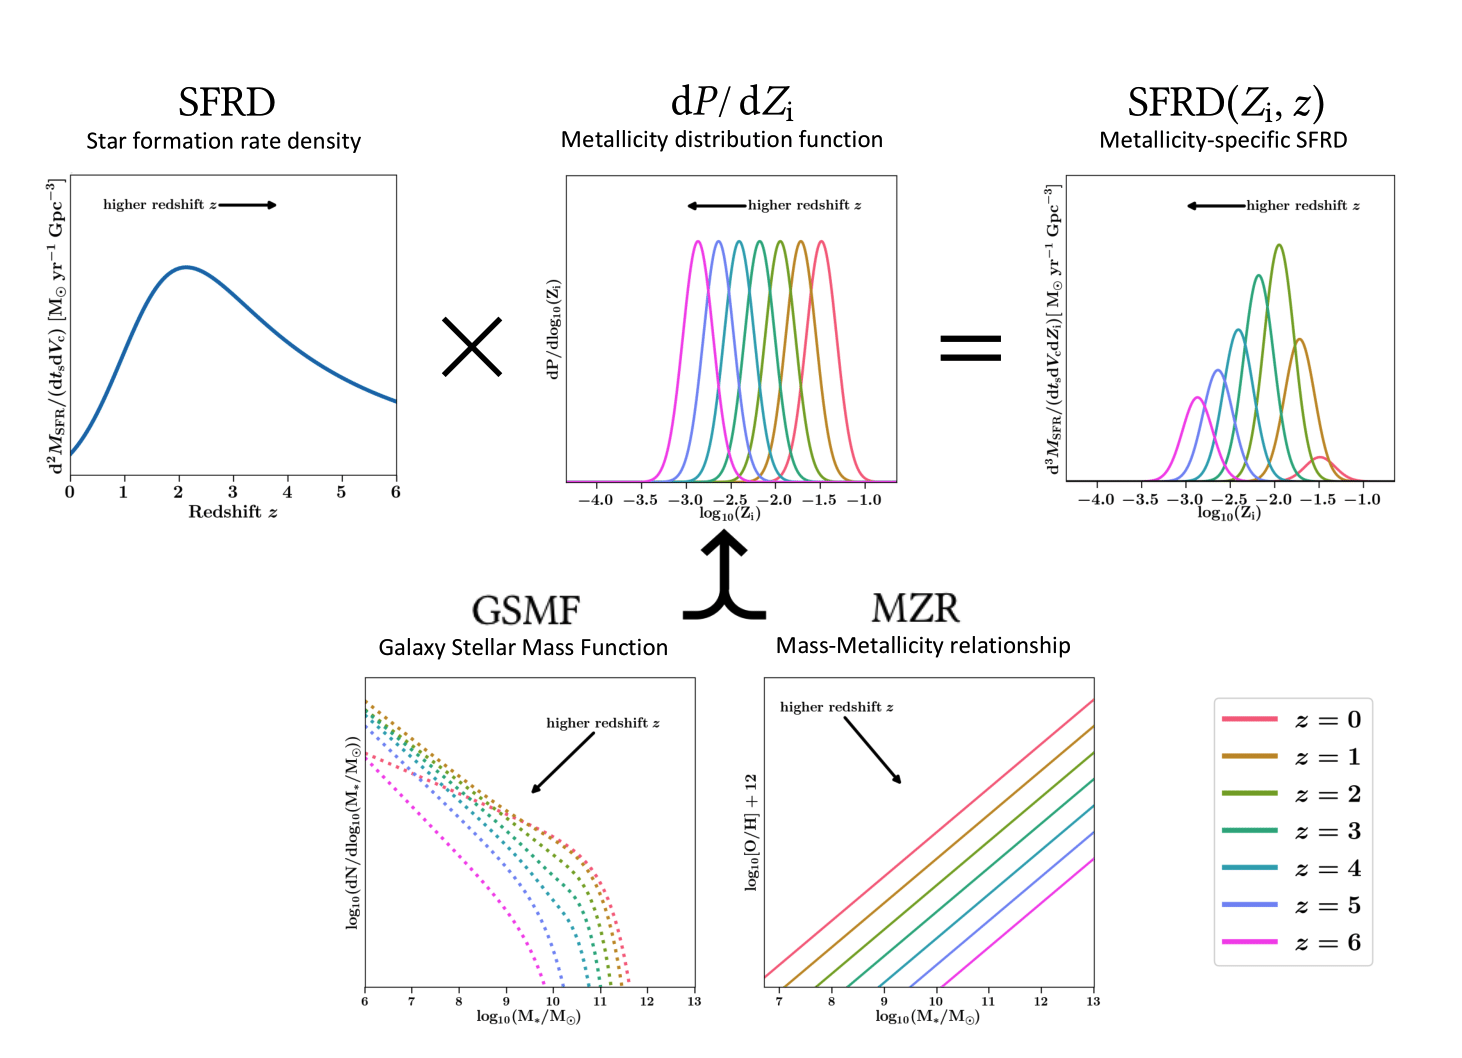


Typically, the SFRD(Z,z) (MSSFR) is created by combining a Star formation rate density (SFRD) with a metallicity distribution function dP/dZ. The latter is typically constructed by combining a galaxy stellar-mass function (GSMF) with a mass-metallicity relationship

For this script we assume that the SFR(z) and the metallicity distribution are independent of each other.
Hence the SFR is simply a normalization to the PDF of the metallicity distribution. Note that these distributions are averages over all galaxies at a specific redshift z and hence do not apply to specific galaxies.

The script allows for several combinations of distributions.
To this end we have to define the following steps


1 - Instance of the MSSFR class where we define constants

2 - Pick a SFR distribution

3 - Pick a metallicity distribution.

Note that although this is meant to be used in the cosmic integration pipeline, 
this class can be independently used to plot distributions or as input for other calculations

4 - Example of plotting

5 - Examples of plotting the SFRD, the GSMF and the MZR relations (Figures 11, 13, and 14 from the COMPAS methods paper) 



# Paths needed

In [24]:
import os

pathNoteBook     = os.getcwd()
pathClassMSSFR  = pathNoteBook + '/PythonScripts/'



# Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#custom scripts
sys.path.append(pathClassMSSFR)
import ClassMSSFR

# 1 - Instance MSSFR class

To create an instance we need to define the following parameters;

Here are the possible parameters and their default values

    verbose             =False,
    
    metallicityGrid     =None,
    
    binInLogSpace        =True,
    metallicityLowerLimit=1E-90, 
    metallicityUpperLimit=1.
                 
    logOH12sun           =8.69,     
    solarMetallicity     =0.0142, 
    cosmo                =None

verbose:
    
    If to print messages of intermediate during the calculation
    
metallicityGrid:
    
    The grid assumed in order to create the metallicity bins dZ. By default set to None
    and in a pipeline it is automatically passed from the ClassCOMPAS file.
    
    
binInLogSpace:
    
    To create the bin edges you can either choose the midpoint between Z1 and Z2 or 
    alternatively you can choose the midpoint between log(Z1) and log(Z2). Since most distributions
    work in the logZ space it seemed more appropriate. The difference is not large. Else it hints
    of having too few gridpoints in metallicity since the curve changes a lot between Z1 and Z2.
    
metallicityLowerLimit:

    Since we integrate over dZ we need to define a lower limit 
    of the metallicity mass Fraction Z in our integral.
    We set it close to zero, but non-zero to avoid division by zero errors
    
metallicityUpperLimit:

    Since we integrate over dZ we need to define a upper limit 
    of the metallicity mass Fraction Z in our integral. 
    Since a fraction cannot go higher than 1 we set it to 1.
    
logOH12sun:

    The assumed solar oxygen abundance (Asplund)
    
solarMetallicity:

    The assumed solar metallicity mass fraction (Asplund)
    
cosmo:

    The assumed universe (omegaM, Omega Lambda etc) to translate between age/distance/time.
    If None it is set to WMAP9. In the cosmic integration pipeline the class is automatically is set by the
    ClassCosmicIntegrator.

In [3]:
#We use the defaults and for illustration purposes invent our own grid

#Absolute metallicities
metallicityGrid = np.logspace(-4, -1.5,100)

MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


# 2 - Pick a SFR distribution

In [4]:
print(MSSFR.printSFRoptions())


        Default instance:
        self.SFRprescription       = None 

        pass string
        Current Options  = 'Madau et al. (2014)'
                           'Madau et al. (2017)'
                           'Strolger et al. (2004)'
                           'Neijssel et al. (2019)'
                           'Custom SFR'

        If you use Custom SFR also set the constants
        you want to use

        self.customSFR = [a,b,c,d] 
        
        which are used in a Madau et al like formula (see source code)

        
None


In [5]:
# Based on the options above lets pick the one of the paper

MSSFR.SFRprescription = 'Neijssel et al. (2019)'

# 3 Pick a metallicity distribution

The metallicity distribution comes in two types of flavours.

###  3.1 Mass metallicity and galaxy stellar mass function

The first combines a densitity distribution of galaxy stellar masses (GSMF) 
with a mass metallicity relation (MZ) relation in order to create a metallicity density function.
In our code instead we translate from metallicity to mass to solve the integral hence we use the inverse
ZM functions. The original MZ functions are still in the source code for plotting/testing purposes


If you want to use these variations then first set the metallicity prescription to 'MZ_GSMF'


In [6]:
MSSFR.Zprescription = 'MZ_GSMF'

Then pick your favourite GSMF and MZ relation
To look at the options. Please note that not all distributions are metallicity dependent
and some rely on fits to the results of the original paper and therefore can behave poorly when pushed to extremes such as at high redshifts for example Furlong et al.

In [7]:
MSSFR.printGSMFoptions()


        If you use MZ and GSMF relations
        i.e. self.Zprescription    = 'MZ_GSMF'

        Default instance
        self.GSMFprescription      = None
        Current Options = Panter et al. (2004) Single, 
                          Furlong et al. (2015) Single,
                          Furlong et al. (2015) Double
        


In [8]:
MSSFR.printZMoptions()


        If you use MZ and GSMF relations
        i.e. self.Zprescription    = 'MZ_GSMF'

        Default instance
        self.ZMprescription        = None
        Current Options = Ma et al. (2016),
                      Langer et al. (2006)
                      Langer et al. +offset (2006)
        


In [9]:
# Set to our old default model Barrett et al

MSSFR.GSMFprescription = 'Panter et al. (2004) Single'
MSSFR.ZMprescription   = 'Langer et al. (2006)'

# 3.2 redshift dependent log-normal distribution

Instead of a MZ-relation and GSMF you can use a redshift dependent log-normal distribution (see paper)
for more details. 

To use this method set the metallicity prescription to 'logNormal'

In [10]:
MSSFR.Zprescription = 'logNormal'


Note that although the code should ignore any chose GSMF/ZM relation when using this option (or vice-versa)
it is still nicer to set those to None just in case and for clarity :). 
    

In [11]:
#then pick your favourite option for the logNormal
MSSFR.printLogNormaloptions()


        If you use Log normal 
        i.e. self.Zprescription    = 'logNormal'

        Default instance
        self.logNormalPrescription      = None
        Current Options = 'Neijssel Phenomenological'
                          'Custom Phenomenological'

        If you use Custom Phenomenological remember to 
        additionally set 

        self.customLogNormal = [Z0, alpha, sigma]
        


In [12]:
MSSFR.logNormalPrescription ='Neijssel Phenomenological'

del MSSFR

# 4 Example of accessing function /plotting

The MSSFR class also has the function to return the fraction of SFR in a metallicity bin.

    MSSFR.returnMSSFR(self, metallicity=None, agesBirth=None, redshiftBirth=None)

The code is constructed such that it calculates the MSSFR for all systems coming from a specific metallicity given that you know their agesBirth or redshiftBirth (depending on the chosen MSSFR you need one or the other)

Note that if we define our own grid of metallicities and time at which we want to know the MSSFR 
then we can use this same function to visualise our assumed distribution.
Of course we can also directly calculate any subfunctions to plot them :)


In [13]:
#lets start from scratch



In [14]:
metallicityGrid = np.logspace(-4, -1.5,100)

MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)
#SFR
MSSFR.SFRprescription = 'Neijssel et al. (2019)'

#metallicity
MSSFR.Zprescription = 'logNormal'
MSSFR.logNormalPrescription ='Neijssel Phenomenological'



ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


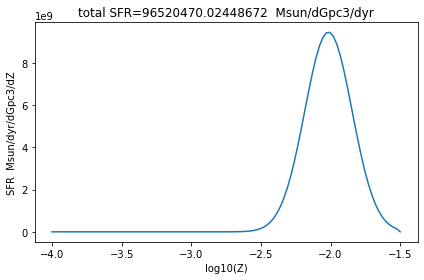

In [15]:
# What is our Z distribution at redshift 2

metallicityGrid = np.logspace(-4, -1.5,100)


SFRrate = np.zeros(len(metallicityGrid))

#our prescriptions do not need agesBirth only 
#redshift but require dummy value
redshift  = np.array([2])
agesBirth = redshift

for nrZ, Z in enumerate(metallicityGrid):
    SFRrate[nrZ] = MSSFR.returnMSSFR( metallicity=Z,\
                   agesBirth=agesBirth, redshiftBirth=redshift)
    
    
bins  = MSSFR.metallicityBinEdges
dZ    = np.diff(bins)

SFR_dZ = np.divide(SFRrate, dZ)
    
fig, axes = plt.subplots(1,1)

axes.plot(np.log10(metallicityGrid), SFR_dZ)
axes.set_title('total SFR=%s  Msun/dGpc3/dyr' %(np.sum(SFRrate)))
axes.set_xlabel('log10(Z)')
axes.set_ylabel('SFR  Msun/dyr/dGpc3/dZ')
plt.tight_layout()
plt.show()

# 5 Example of plotting different SFR, GSMF and MZ relations 
examples of how to produce plots for different options of SFR, GSMF and MZ. These figures are also presented in the COMPAS method paper in the section post-processing. 

In [16]:
import matplotlib.pyplot as plt
#Set latex environment for plots/labels
import matplotlib
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  


# 5.1 Plot the SFR options
in the following blocks we will plot the currently implemented star formation rate perscriptions (SFRs). The code and figure is based on Neijssel+2019, and this code will reproduce the figure in the COMPAS method paper. 

In [17]:
print(MSSFR.printSFRoptions())


        Default instance:
        self.SFRprescription       = None 

        pass string
        Current Options  = 'Madau et al. (2014)'
                           'Madau et al. (2017)'
                           'Strolger et al. (2004)'
                           'Neijssel et al. (2019)'
                           'Custom SFR'

        If you use Custom SFR also set the constants
        you want to use

        self.customSFR = [a,b,c,d] 
        
        which are used in a Madau et al like formula (see source code)

        
None


 we will now plot several of the available star formation rate density (SFRD) prescriptions that are available in COMPAS. This re-creates Figure 11 from the COMPAS methods paper (figure showing the SFRD as a function of redshift for the four default available options in COMPAS) 

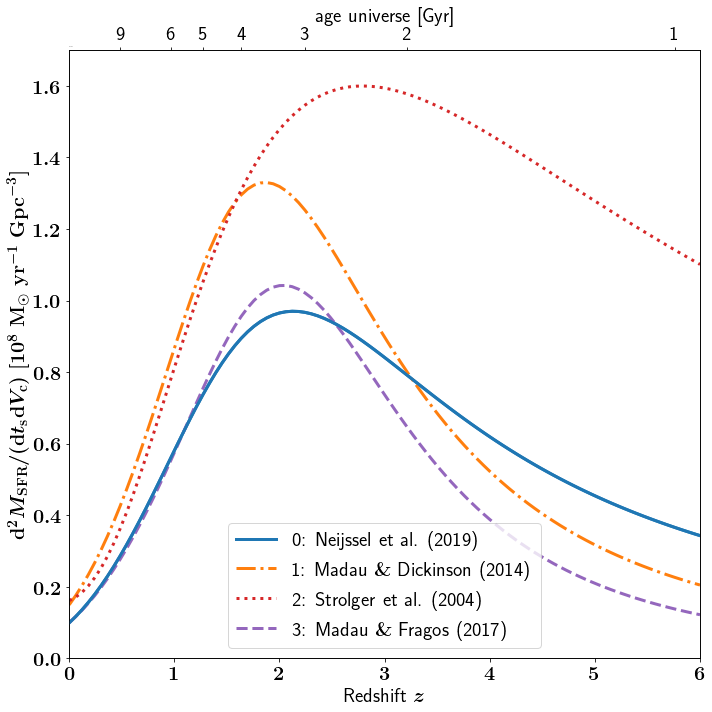

In [18]:
# fontsize
fs = 20

clist=['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Plotting the SFR prescriptions
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = MSSFR.cosmology.age(redshifts).value

fig, axes = plt.subplots(1,1, figsize=(10,10))
axes.plot(redshifts, MSSFR.SFR_Neijssel(redshifts), c=clist[0], lw=3., label='0: Neijssel et al. (2019)', linestyle='-')
axes.plot(redshifts, MSSFR.SFR_Madau(redshifts),    c=clist[1], lw=3., label=r'1: Madau $\&$ Dickinson (2014)', linestyle='-.')
axes.plot(redshifts, MSSFR.SFR_Strolger(ages),      c=clist[2], lw=3., label='2: Strolger et al. (2004)', linestyle=':')
axes.plot(redshifts, MSSFR.SFR_Madau2(redshifts),   c=clist[3], lw=3., label=r'3: Madau $\&$ Fragos (2017)', linestyle='--')


axes2  = axes.twiny()
axes2.plot(redshifts, MSSFR.SFR_Neijssel(redshifts), c=clist[0], lw=3., label='Preferred model')


#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,6, 9]) #Gyr
ageUniverse = MSSFR.cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

axes2.set_xticks(redshiftTicks)
axes2.set_xticklabels(agelabels)

# axes layout
nameX = r'Redshift $z$'
nameY = r'$ {\rm{d}}^2M_{\rm{SFR}}/({\rm{d}}t_{{\rm{s}}}{\rm{d}}V_{\rm{c}}) \   [10^8\ {\rm{M}}_{\odot}\  {\rm{yr}}^{-1}\ {\rm{Gpc}}^{-3}]$'
axes.legend(loc=8, prop={'size':fs})
axes.yaxis.offsetText.set_fontsize(0.1)
axes.set_ylim(0, 1.7*10**8)
# axes.set_xlim(0, 6)
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)
axes.set_xlim(0,6)

# second x-axis for age
nameX2 = 'age universe [Gyr]'
# axes2.xaxis.labelpad = 20
axes2.set_xlabel(nameX2, fontsize=fs)
axes2.tick_params(labelsize=fs)
axes2.set_xlim(0,6)

plt.tight_layout()
plt.savefig('./SFRplot.png', dpi=100)
plt.show()

# 5.2 plot the Galaxy stellar mass function GSMF 

the blocks below show how to plot and use the galaxy stellar mass functions as shown in Figure 13 of the COMPAS methods paper 

From Neijssel+2019:
Stellar mass density functions are given as schechter functions of the form:

$$ \phi(M) dM = \phi^{*} \left(\frac{M}{M_*}\right)^{\alpha} e^{\left(\frac{-M}{M_*}\right)} dM $$

$\phi^*$ = overall normalization

*M_*$ = determines turnover from power-law to exponential drop of

$\alpha $  = determines slope power low for  $M\leq M_*$

The prescription by Panter et al. 2004 is redshift independent and therefore
we just need to implement their notation. Alternatively we use a redshift dependent prescription by Furlong 
et al. They have both a single schechter function in the same form as above, as well as a double schechter function of the form

$$ \phi(M) dM = \left[ \phi_1 \left(t\right)^{\alpha_1} + 
                       \phi_2 \left(t\right)^{\alpha_2} \right] * e^{-\frac{M}{M_c}} $$
                       
However they only show the constants and several redshifts. Hence most of this notebook is dedicated
to turning this into a parametrized form to be used at any redshift. 

## Plotting the tabulated Furlong prescription
The plots in the paper such as Furlong et al do NOT plot M vs phi dM
instead they plot logM vs phi dlogM

so we need to transform the equation a bit


$$ y = log_{10}(x) $$
$$ \frac{dy}{dx} = \frac{1}{x} $$
$$ dx = x dy$$

since x = M/M* we have a +1 in the alpha term for the schechter dlog10 function

In [19]:
def singleSchechterPerLog10(logM, logMc,  phi,  alpha):
    M  = 10**logM
    Mc = 10**logMc
    x  = M/Mc
    schechter = phi * ((x)**(alpha+1)) * np.exp(-x)
    return schechter
def doubleSchechterPerLog10(logM, logMc,  phi1,  a1, phi2, a2):
    M  = 10**logM
    Mc = 10**logMc
    x  = M/Mc
    schechter =(phi1 * ((x)**(a1+1))+  phi2 * ((x)**(a2+1))) * np.exp(-x)
    return schechter


def doubleSchechterPerLog10FurlongPolynomial(logM, z, power):
    logMc, phi1, a1, phi2, a2 = polynomialFitDoubleSchechter(z, power)
    schechter = ((phi1*(10**((a1+1)*(logM-logMc)))) + (phi2*(10**((a2+1)*(logM-logMc)))))\
               *(np.exp(-pow(10,logM-logMc)))
    return schechter


def doubleSchechterPerLog10FurlongLineair(logM, z):
    logMc, phi1, a1, phi2, a2, ratio = lineairFitDoubleSchechter(z)
    schechter = ((phi1*(10**((a1+1)*(logM-logMc)))) + (phi2*(10**((a2+1)*(logM-logMc)))))\
               *(np.exp(-pow(10,logM-logMc)))
    return schechter


def singleSchechterPerLog10FurlongPolynomial(logM, z, power):
    logMc, phi, alpha = polynomialFitSingleSchechter(z, power)
    schechter = phi*(10**((alpha+1)*(logM-logMc)))*(np.exp(-pow(10,logM-logMc)))
    return schechter


def singleSchechterPerLog10FurlongLineair(logM, z):
    logMc, phi, alpha = lineairFitSingleSchechter(z)
    schechter = phi*(10**((alpha+1)*(logM-logMc)))*(np.exp(-pow(10,logM-logMc)))
    return schechter


In [20]:
#In Furlong et al they note that a double schechter function
#fits the data better at the high galaxy stellar masses (log10M > 11)
def lineairFitSingleSchechter(z):

    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1
        
    fitlogMc        = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
    fitphi1          = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
    fita1            = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])

    
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    
    fitvalues = [fitlogMc, fitphi1, fita1]
    thresholds = [0.0, 0.5, 1.0, 2.0, 3.0, 10000000]
    r          = []
    for nrv, values in enumerate(fitvalues):
        dz     = np.diff(fitredshifts)
        dydz   = np.divide(np.diff(values), dz)
        yvalues= np.zeros(nr)
        for nrz, redshift in enumerate(thresholds[:-1]):
            mask = (z>= thresholds[nrz]) & (z<=thresholds[nrz+1])
            if nrz == 0 :
                #interpolate from z0.5 down
                dz   = 0.5 - z[mask]
                interpolatedValue  = values[nrz+1] - np.multiply(dz, dydz[nrz])
            else:
                #interpolate up
                dz   = z[mask] - redshift
                interpolatedValue  = values[nrz] + np.multiply(dz, dydz[nrz])
            yvalues[mask] =  interpolatedValue
        r.append(yvalues)
        
    r[1][r[1] <0] = 0  #phi1
    return r[0], r[1], r[2]

def lineairFitDoubleSchechter(z):

    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1

    
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    fitlogMc     = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
    fitphi1      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
    fita1        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
    fitphi2      = np.array([0.0,  0.08,   0.48, 0.8, 0.61, 0.43])*10**-3
    fita2        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])
    
    ratioPhi1Phi2 = np.divide(fitphi2, fitphi1) #Do it in this order because phi2 is zero
    
    fitvalues  = [fitlogMc, fitphi1, fita1, fitphi2, fita2, ratioPhi1Phi2]
    thresholds = [0.0, 0.5, 1.0, 2.0, 3.0, 10000000]
    r          = []
    for nrv, values in enumerate(fitvalues):
        dz     = np.diff(fitredshifts)
        dydz   = np.divide(np.diff(values), dz)
        yvalues= np.zeros(nr)
        for nrz, redshift in enumerate(thresholds[:-1]):
            mask = (z>= thresholds[nrz]) & (z<=thresholds[nrz+1])
            if nrz == 0 :
                #interpolate from z0.5 down
                dz   = 0.5 - z[mask]
                interpolatedValue  = values[nrz+1] - np.multiply(dz, dydz[nrz])
            else:
                #interpolate up
                dz   = z[mask] - redshift
                interpolatedValue  = values[nrz] + np.multiply(dz, dydz[nrz])
            yvalues[mask] =  interpolatedValue
        r.append(yvalues)
        
    r[3][r[3]<0]  = 0  #phi2
    r[1][r[1] <0] = 0  #phi1
    r[4][r[4]<-2] = -2 #a2
    return r[0], r[1], r[2], r[3], r[4], r[5]

def polynomialFitSingleSchechter(z, power):
    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1

    fitredshifts = np.array([0.1, 0.5, 1.0,2.0, 3.0, 4.0])
    fitlogMc     = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
    fitphi       = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
    fita         = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])
        
    fitvalues    = [fitlogMc, fitphi, fita]
    y            = []
    
    for nrv, values in enumerate(fitvalues):
        ysub         = np.zeros(nr)
        coefficients = np.polyfit(fitredshifts,values, power)[::-1]
        for nrpower, coefficient in enumerate(coefficients):
            ysub     = np.add(ysub, coefficient*np.power(z,nrpower))
        y.append(ysub) 
        
    return y[0], y[1], y[2]

def polynomialFitDoubleSchechter(z, power=5):
    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1    
        #Constants for double schechter fit
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    fitlogMc2    = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
    fitphi1      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
    fita1        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
    fitphi2      = np.array([0.0, 0.08, 0.48, 0.8, 0.61, 0.43])*10**-3
    fita2        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])
    
    fitvalues    = [fitlogMc2, fitphi1, fita1, fitphi2, fita2]
    y            = []
    
    for nrv, values in enumerate(fitvalues):
        ysub         = np.zeros(nr)
        coefficients = np.polyfit(fitredshifts,values, power)[::-1]
        for nrpower, coefficient in enumerate(coefficients):
            ysub     = np.add(ysub, coefficient*np.power(z,nrpower))
        y.append(ysub)       
        
    return y[0], y[1], y[2], y[3], y[4]

# The constants from the papers

In [21]:
#GSMF from panter et al 2004
#https://academic.oup.com/mnras/article/355/3/764/952806
#Used in Norman & Langer  2006
#http://iopscience.iop.org/article/10.1086/500363/meta
#Note that this is redshift independent!
logMc = np.log10(7.64*(10**10))
phi   = 7.8* (10**(-3)) 
alpha = -1.16


#From Furlong et al https://academic.oup.com/mnras/article-abstract/450/4/4486/1747992
#logMc defines the turnover between power law and exponential drop
#Reproducing figure A1

fitRedshifts   = np.array([0.1, 0.5, 1.0,2.0, 3.0, 4.0])
#fit values single schechter
logMc_s        = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
phi_s          = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
a_s            = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])

#fit values double schechter
logMc_d     = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
phi1_d      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
a1_d        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
phi2_d      = np.array([0.0,  0.08,   0.48, 0.8, 0.61, 0.43])*10**-3
a2_d        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])

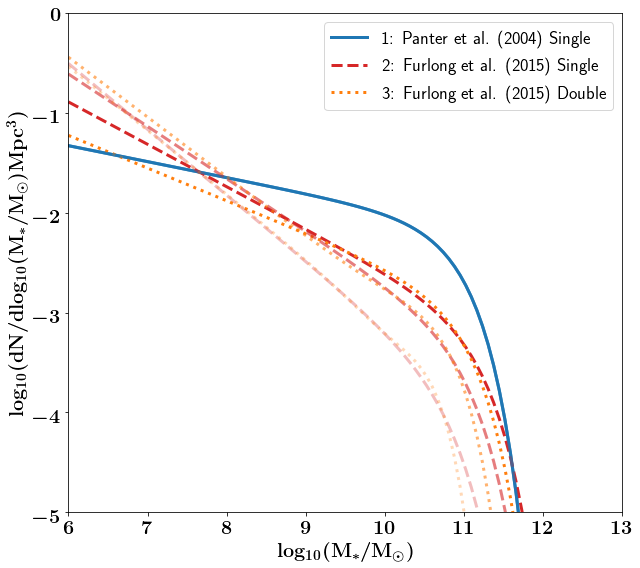

In [22]:
logM      = np.linspace(6,13,100)
redshifts = [0., 1.5, 3.]
#color per prescription
mycolors = clist
#linestyle per redshift
linestyles= ['-', '--', ':']
alphas = [1,0.6,0.3]


fig, axes = plt.subplots(1,1, figsize=(9,8))

for nrz, z in enumerate(redshifts):
    if nrz == 0:
        label1, label2, label3 = '1: Panter et al. (2004) Single',\
        '2: Furlong et al. (2015) Single','3: Furlong et al. (2015) Double'
    else:
        label1, label2, label3 = None, None, None
    Norman   = singleSchechterPerLog10(logM, logMc,  phi,  alpha)
    axes.plot(logM, np.log10(Norman), c=mycolors[0], label=label1, lw=3,  linestyle=linestyles[0], alpha=alphas[nrz])
    Furlongsingle = singleSchechterPerLog10FurlongLineair(logM, z)
    axes.plot(logM, np.log10(Furlongsingle), c=mycolors[2], label=label2, lw=3,  linestyle=linestyles[1], alpha=alphas[nrz])
    FurlongDouble = doubleSchechterPerLog10FurlongLineair(logM, z)
    axes.plot(logM, np.log10(FurlongDouble), c=mycolors[1], label=label3, lw=3, linestyle=linestyles[2], alpha=alphas[nrz])

nameX = r'$\rm log_{10}(M_{*}/M_{\odot})$'
nameY = r'$\rm log_{10}( dN / dlog_{10}(M_*/M_{\odot})Mpc^{3})$'

#axes.set_yscale('log')
axes.set_ylim(bottom=-5, top=0)
axes.set_xlim(left=6, right=13)
axes.legend(prop={'size': 18})
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)

plt.tight_layout()
plt.savefig('./GSMFplot.png')
plt.show()

# 5.3 plot the MZR relations 

blocks below show how to use and plot the mass-metallicity relations as shown in Figure 14 of the COMPAS methods paper.

From Neijssel+2019: we get the relationship between the galaxy stellar mass and the oxygen to hydrogen 
number density. Using the relation between number density and mass fractino above we translate this to a metallicity.
This metallicity is that of the interstellar gas. We assume that the stars that form at redshift z have the same metallicity as that of the interstellar gas


Below we plot the different MZ relations from the MSSFR class as found in the respective papers.
Given that in the project we want to use the inverse (ZM-relations) we test these too.

In [23]:
dictMZ      = {'Ma et al. (2015)':2,  'Langer et al. (2006)':0   ,\
               'Langer et al. + offset (2006)':1}

#I want some colours from viridis and some custom
#cm          = plt.get_cmap('viridis')
#nColors     = 4#want three colours but not yellow
#colours     = [cm(x) for x in np.linspace(0,1 , nColors)] 

colours     = ['gray','gray','purple', 'k', 'k', 'c']
linestyles  = [':', '-', '-', '-', '--', '-']

MZfunctions = [MSSFR.Langer2005MZ,  None, MSSFR.Ma2015MZ]

ZMfunctions = [MSSFR.Langer2005ZM,  MSSFR.Langer2005OffsetZM, MSSFR.Ma2015ZM]








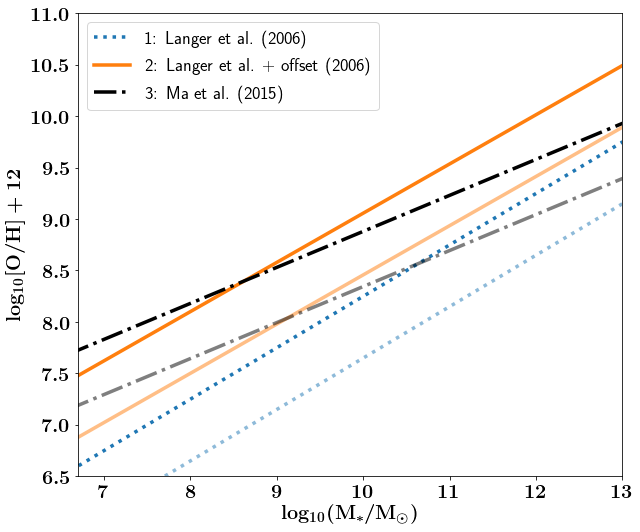

In [24]:
fs=20

MSSFR.logOH12sun            = 8.69    #fraction number density solar
MSSFR.solarMetallicity      = 0.0142  #fraction mass in metals solar, based on Asplund
clist=['#1f77b4', '#ff7f0e', 'k', '#bcbd22', '#17becf']

dictMZ      = {'3: Ma et al. (2015)':2,  '1: Langer et al. (2006)':0   ,\
               '2: Langer et al. + offset (2006)':1}

#I want some colours from viridis and some custom
#cm          = plt.get_cmap('viridis')
#nColors     = 4#want three colours but not yellow
#colours     = [cm(x) for x in np.linspace(0,1 , nColors)] 


linestyles  = [':', '-', '-.', '-', '--', '-']

MZfunctions = [MSSFR.Langer2005MZ,  None, MSSFR.Ma2015MZ]

ZMfunctions = [MSSFR.Langer2005ZM,  MSSFR.Langer2005OffsetZM, MSSFR.Ma2015ZM]


logZZsun  = np.linspace(-3, 3, 100)



plot      = ['1: Langer et al. (2006)', \
             '2: Langer et al. + offset (2006)',\
             '3: Ma et al. (2015)']

fig, axes = plt.subplots(1,1, figsize=(9,7.5))
logOH12sun  = 8.69

for prescription in plot:
    i         = dictMZ[prescription]
    
    # plot at the following redshift
    z=0
    #translate back to LogM using inverse
    logM      = ZMfunctions[i](10**logZZsun, z)
    #I want to plot logOH12 not ZZsun
    logOH12   =  MSSFR.LogOH12vsLogZZsun(logZZsun, inValue='logZZsun')
    #to prevent overlapping dashed lines
    axes.plot(logM, logOH12, c=clist[i], label=prescription,\
              linestyle=linestyles[i], lw=3.5)

    z=2
    logM      = ZMfunctions[i](10**logZZsun, z)
    #I want to plot logOH12 not ZZsun
    logOH12   =  MSSFR.LogOH12vsLogZZsun(logZZsun, inValue='logZZsun')
    #to prevent overlapping dashed lines
    axes.plot(logM, logOH12, c=clist[i],\
              linestyle=linestyles[i], lw=3.5, alpha=0.5)    


axes.legend(loc=2, prop={'size':18})
axes.set_ylim(6.5, 11)
    
axes.set_xlim(6.7,13)

nameX = r'$\rm log_{10}(M_{*}/M_{\odot})$'
nameY = r'$\rm log_{10}[O/H]+12$'
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)


plt.tight_layout()
plt.savefig('./MZrelations.png')
plt.show()
plt.close()